In [1]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import scipy.optimize as optimize
from uncertainties import ufloat, umath
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values as noms
from textable import table

# bypass UsageError when there is no GUI
try:
    %matplotlib inline
except:
    pass

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 16
plt.style.use('ggplot')

In [2]:
DataStructure = namedtuple('DataStructure', 'hopg_down hopg_down_back hopg_up hopg_up_back au_1 au_2')
data = DataStructure(
    hopg_down = {
        'file': './raw/HOPG-DOWN.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG downwards',
        'name': 'down',
        'preselection': {
            'x': [1.05, 2],
            'y': [1.48, 2],
        },
        'bounds': [[[0.3, 0.3], [0.3, 0.1]],
                   [[-0.85, 1.4], [-0.85, 1.2]],
                  ],
        'anker': 32,
    },
    hopg_down_back = {
        'file': './raw/HOPG-DOWN-BACK.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG downwards BACK',
        'name': 'down-back',
        'preselection': {
            'x': [1.05, 2],
            'y': [1.48, 2],
        },
        'bounds': [[[0.33, 0.5], [0.33, 0.3]],
                   [[-0.85, 1.05], [-0.85, 0.85]],
                  ],
        'anker': 40,
    },
    hopg_up = {
        'file': './raw/HOPG-UP.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG upwards',
        'name': 'up',
        'preselection': {
            'x': [0.872, 2],
            'y': [1.75, 2],
        },
        'bounds': [[[0.35, 0.7], [0.35, 0.48]],
                   [[-0.85, 1.4], [-0.85, 1.2]],
                  ],
        'anker': 39,
    },
    hopg_up_back = {
        'file': './raw/HOPG-UP-BACK.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG upwards BACK',
        'name': 'up-back',
        'preselection': {
            'x': [2, 2],
            'y': [2, 2],
        },
        'bounds': [[[0.55, 0.6], [0.55, 0.4]],
                   [[-0.7, 2.15], [-0.7, 1.9]],
                  ],
        'anker': 35,
    },
    au_1 = {
        'file': './raw/AU-1-1.txt',
        'dim': np.linspace(0, 300, 512),
        'title': '1. AU',
        'name': 'au1',
    },
    au_2 = {
        'file': './raw/AU-2-2.txt',
        'dim': np.linspace(0, 300, 512),
        'title': '2. AU',
        'name': 'au2',
    }
)

for obj in data:
    im_data = np.genfromtxt(obj['file'])
    im_data = np.flipud(im_data)
    obj['data'] = im_data

In [3]:
for i, obj in enumerate(data):
    plt.figure(figsize=(10, 10))
    if(obj['dim'].size > 200):
        plt.imshow(obj['data'], origin='lower')
        plt.grid(b=False)
    else:
        plt.pcolormesh(obj['dim'], obj['dim'], obj['data'])
    plt.title(obj['title'])
    plt.xlabel(r'$x / \mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y / \mathrm{nm}$', fontsize=16)
    plt.axis('equal')
    plt.savefig('build/plots/{}.pdf'.format(obj['title'].replace(' ', '_')))
    _ = plt.clf()

In [4]:
def linear_func(x, a, b):
    return np.array(a) * x + b

Finde lokale Maxima und Plotte diese

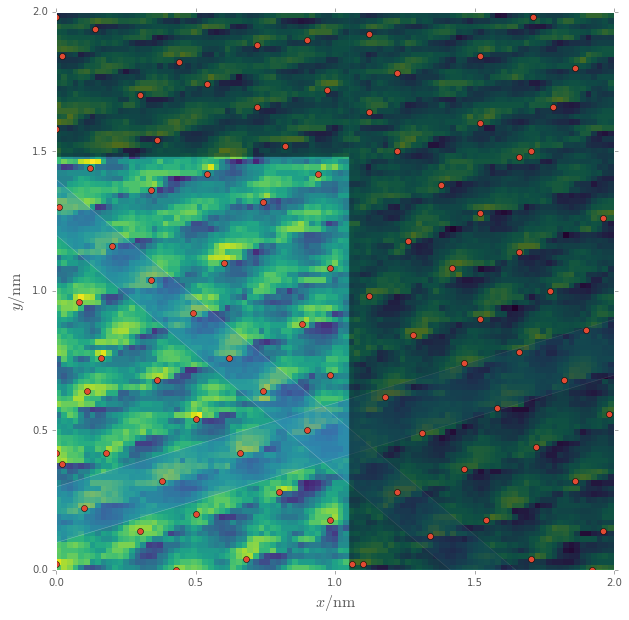

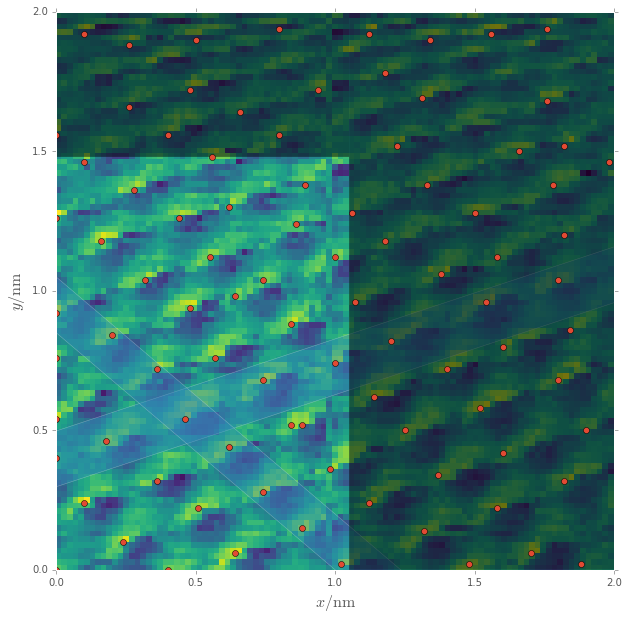

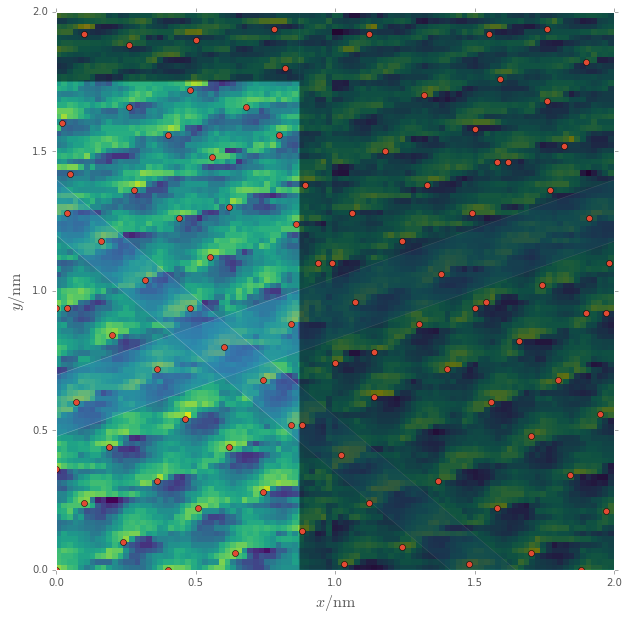

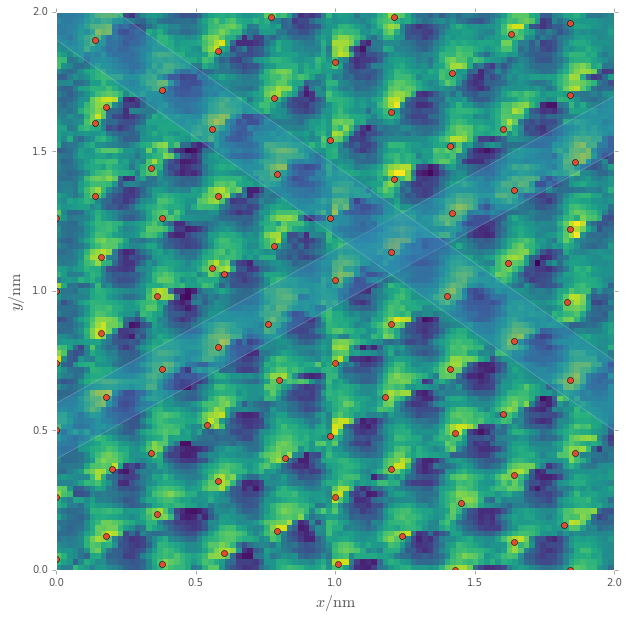

In [5]:
# took this from http://stackoverflow.com/a/9113227

neighbourhood_size = 12
threshhold = 1e-11

for data_slice in data[:4]:
    ds = data_slice['data']
    bounds = data_slice['bounds']
    preselection = data_slice['preselection']
    name = data_slice['name']
    d_maxima = filters.maximum_filter(ds, neighbourhood_size)
    maxima = (ds == d_maxima)
    d_min = filters.minimum_filter(ds, neighbourhood_size)
    diff = ((d_maxima - d_min) > threshhold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/100
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/100  
        y.append(y_center)
    data_slice['xy'] = np.array([x, y])

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(data_slice['dim'], data_slice['dim'], data_slice['data'])
    plt.plot(np.array(x), np.array(y), 'o')
    plt.xlabel(r'$x/\mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y/\mathrm{nm}$', fontsize=16)
    plt.axis('equal')
    plt.xlim(0, 2)
    plt.ylim(0, 2)

    xs = np.linspace(0, 2, 10000)
    for u, l in bounds:
        plt.fill_between(xs, linear_func(xs, *l), linear_func(xs, *u), alpha=0.4)
    plt.fill_between(xs[xs < preselection['x'][0]],
                     preselection['y'][0],
                     2, alpha=0.5, edgecolor='none', facecolor='k')
    plt.fill_betweenx(xs, preselection['x'][0], 2, alpha=0.5, edgecolor='none', facecolor='k')
    plt.savefig('build/plots/hopg_{}_selection.pdf'.format(name))
    plt.show()

Fitte lineare Funktion an die Messpunkte innerhalb der Selektion. Berechne aus der Steigung die Richtung der Gittervektoren und skaliere die Länge auf die Zahl der für den Fit genutzten Gittervektoren.

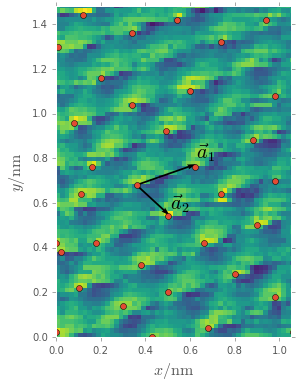

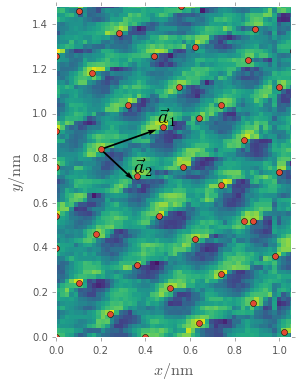

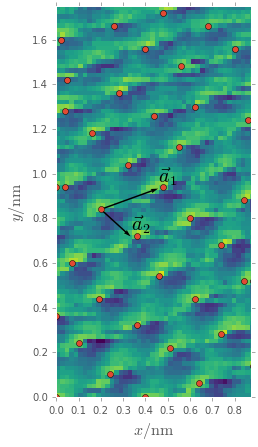

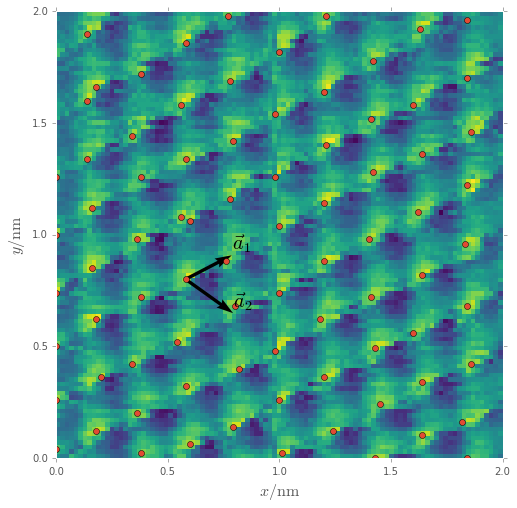

In [6]:
for data_slice in data[:4]:
    name = data_slice['name']
    bounds = data_slice['bounds']
    preselection = data_slice['preselection']
    x, y = data_slice['xy']
    gvs = []
    p = data_slice['anker']

    for u, l in bounds:
        selection = (
            (y < linear_func(x, *u)) 
            & (y > linear_func(x, *l)) 
            & (np.array(x) < preselection['x'][0]) 
            & (np.array(y) < preselection['y'][0])
        )
        fit_xs = np.array(x)[selection]
        fit_ys = np.array(y)[selection]

        coeff, cov = optimize.curve_fit(linear_func, fit_xs, fit_ys)
        errs = np.sqrt(np.diag(cov))
        dx = ufloat((np.max(fit_xs) - np.min(fit_xs)) / (len(fit_xs) - 1), np.std(fit_xs) / (len(fit_xs) - 1))
        gvs.append([dx, ufloat(coeff[0], errs[0]) * dx])
        xs = np.linspace(0, 2)
    
    gvs = unp.uarray([[v.n for v in vec] for vec in gvs],
                     [[v.s for v in vec] for vec in gvs])
    data_slice['gvs'] = gvs
    
    data_scale = len(data_slice['dim']) / np.max(data_slice['dim'])
    plt.figure(figsize=(preselection['x'][0] * 4, preselection['y'][0] * 4))
    # plt.figure(figsize=(10, 10))
    plt.pcolormesh(data_slice['dim'], data_slice['dim'], data_slice['data'])
    plt.plot(np.array(x), np.array(y), 'o')
    plt.quiver(x[p], y[p], noms(gvs[:,0]), noms(gvs[:,1]), angles='xy', scale=1, scale_units='xy')
    # annotate with indices if neccessary
    #for i, xy in enumerate(zip(x, y)):
    #    plt.annotate(i, xy)
    # annotate vectors
    for x, (gv, label) in enumerate(zip(gvs, [r'$\vec{a}_1$', r'$\vec{a}_2$'])):
        plt.annotate(label, data_slice['xy'][:,p] + noms(gv) + np.array([0, 0.03]), fontsize=20)
    plt.xlabel(r'$x/\mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y/\mathrm{nm}$', fontsize=16)
    plt.xlim(0, preselection['x'][0])
    plt.ylim(0, preselection['y'][0])
    plt.savefig('build/plots/hopg_{}_arrows.pdf'.format(name))
    plt.show()

Speichere Vektoren nach `build/tex/`

In [7]:
for data_slice in data[:4]:
    name = data_slice['name']
    for g, i, lt in zip(data_slice['gvs'], ['a', 'b', 'c'], [r'\vec{a}_1', r'\vec{a}_2', r'\vec{b}']):
        with open('build/tex/{}_vec_{}.tex'.format(name, i), 'w') as f:
            f.write(r'''{} =
            \begin{{pmatrix}}
                \SI{{{:L}}}{{\angstrom}}\\
                \SI{{{:L}}}{{\angstrom}}
            \end{{pmatrix}}'''
            .format(lt, *(g * 10)))
        with open('build/tex/{}_vec_{}_len.tex'.format(name, i), 'w') as f:
            f.write(r'''\left|{}\right| = \SI{{{:L}}}{{\angstrom}}'''
            .format(lt, unp.sqrt((g*g).sum()) * 10))

Winkel für HOPG berechnen und speichern

In [8]:
for i, dataset in enumerate(data[:4]):
    name = dataset['name']
    title = dataset['title']
    gv1, gv2 = dataset['gvs']
    angle = unp.arccos(gv1.dot(gv2) / unp.sqrt((gv1**2).sum() * (gv2**2).sum())) * 180 / np.pi
    dataset['angle'] = angle
    with open('build/tex/{}_angle.tex'.format(name), 'w') as f:
        f.write(r'''\angle\left(\vec{{a}}_1,\vec{{a}}_2\right) =
        \SI{{{:L}}}{{\degree}}'''.format(angle))

with open('build/tex/table_vec.tex', 'w') as f:
    f.write(table([r'$\vec{a}_{1,x}$ / \si{\angstrom}',
                   r'$\vec{a}_{1,y}$ / \si{\angstrom}',
                   r'$\vec{a}_{2,x}$ / \si{\angstrom}',
                   r'$\vec{a}_{2,y}$ / \si{\angstrom}',
                   r'$a_1$ / \si{\angstrom}',
                   r'$a_2$ / \si{\angstrom}',
                   r'$\alpha$ / \si{\degree}'],
                  [[d['gvs'][0][0] for d in data[:4]],
                   [d['gvs'][0][1] for d in data[:4]],
                   [d['gvs'][1][0] for d in data[:4]],
                   [d['gvs'][1][1] for d in data[:4]],
                   [umath.sqrt((d['gvs'][0]**2).sum()) for d in data[:4]],
                   [umath.sqrt((d['gvs'][1]**2).sum()) for d in data[:4]],
                   [d['angle'] for d in data[:4]],
                  ]))

Durchschnittswerte berechnen und speichern

In [9]:
alpha_sum, a1_sum, a2_sum = 0, 0, 0
for dataset in data[:4]:
    alpha_sum += dataset['angle']
    a1_sum += dataset['gvs'][0]
    a2_sum += dataset['gvs'][1]

alpha_sum /= 4
a1_sum /= 4
a2_sum /= 4

with open('build/tex/avg_angle.tex', 'w') as f:
    f.write(r'\overline{{\alpha}} &= \SI{{{:L}}}{{\degree}}'.format(alpha_sum))
with open('build/tex/avg_a1_len.tex', 'w') as f:
    f.write(r'\left|\vec{{a}}_1\right| &= \SI{{{:L}}}{{\angstrom}}'.format(10 * (unp.sqrt(a1_sum*a1_sum).sum())))
with open('build/tex/avg_a2_len.tex', 'w') as f:
    f.write(r'\left|\vec{{a}}_2\right| &= \SI{{{:L}}}{{\angstrom}}'.format(10 * (unp.sqrt(a2_sum*a2_sum).sum())))
with open('build/tex/avg_a1.tex', 'w') as f:
    f.write(r'''\overline{{\vec{{a}}_1}} &=
            \begin{{pmatrix}}
                \SI{{{:L}}}{{\angstrom}}\\
                \SI{{{:L}}}{{\angstrom}}
            \end{{pmatrix}}'''
            .format(*(a1_sum * 10)))
with open('build/tex/avg_a2.tex', 'w') as f:
    f.write(r'''\overline{{\vec{{a}}_2}} &=
            \begin{{pmatrix}}
                \SI{{{:L}}}{{\angstrom}}\\
                \SI{{{:L}}}{{\angstrom}}
            \end{{pmatrix}}'''
            .format(*(a2_sum * 10)))

Skalierung...

In [10]:
ahat = 0.2461
x1, y1 = a1_sum
x2, y2 = a2_sum
phi = (y2**2 - y1**2)/(x1**2 - x2**2)
x_scale = ahat * umath.sqrt(phi**2 / (y1**2 + x1**2*phi**2))
y_scale = ahat / umath.sqrt(y1**2 + x1**2*phi**2)
alpha = np.pi/3
with open('build/tex/scale_x.tex', 'w') as f:
    f.write(r's_x = \num{{{:L}}}'.format(x_scale))
with open('build/tex/scale_y.tex', 'w') as f:
    f.write(r's_y = \num{{{:L}}}'.format(y_scale))

In [11]:
y_scale = ufloat(1, 0)
x_scale = umath.sqrt((ahat * np.cos(alpha) - y_scale**2 * y1 * y2)/(x1*x2))
with open('build/tex/scale_x.tex', 'w') as f:
    f.write(r's_x = \num{{{:L}}}'.format(x_scale))
with open('build/tex/scale_y.tex', 'w') as f:
    f.write(r's_y = \num{{{:L}}}'.format(y_scale))

In [12]:
au_x, au_y = np.genfromtxt('raw/AU-1-View-2-Profile.prf', unpack=True, skip_header=30)

In [13]:
def plateaus(x, h1, h2, h3, a1, a2):
    y = np.piecewise(x,
                     [x < a1, (x < a2) & (x >= a1), x >= a2],
                     [h1, h2, h3])
    return y

In [14]:
p0 = [2.2, 1.2, 0.2, 60, 100]
coeff, covar = optimize.curve_fit(plateaus, au_x, au_y, p0=p0)
errs = np.sqrt(np.diag(covar))
print(coeff)

[   2.22589904    1.30413217    0.40988322   60.          100.        ]


/usr/local/lib/python3.5/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


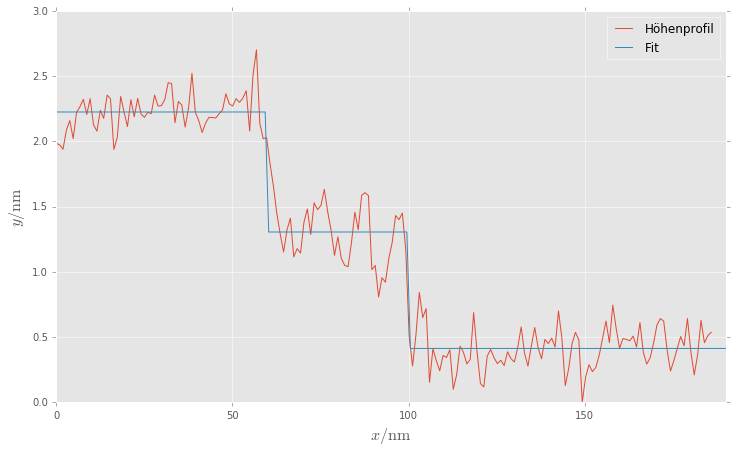

In [15]:
xs = np.linspace(0, 200, 200)
plt.figure(figsize=(12, 7))
plt.plot(au_x, au_y, label='Höhenprofil')
plt.plot(xs, plateaus(xs, *coeff), label='Fit')
plt.ylabel(r'$y / \mathrm{nm}$', fontsize=16)
plt.xlabel(r'$x / \mathrm{nm}$', fontsize=16)
plt.legend(loc='best')
plt.savefig('build/plots/au_plateaus.pdf')
plt.xlim(0, 190)
plt.show()

In [16]:
dh1 = coeff[0] - coeff[1]
dh2 = coeff[1] - coeff[2]
print(dh1, dh2)
with open('build/tex/plateau1.tex', 'w') as f:
    f.write(r'h_1 = \SI{{{:.0f}}}{{\pico\meter}}'.format(dh1 * 1000))
with open('build/tex/plateau2.tex', 'w') as f:
    f.write(r'h_2 = \SI{{{:.0f}}}{{\pico\meter}}'.format(dh2 * 1000))

0.92176687231 0.894248946929
